In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Part 1: Data Generation - Exclusion Zone

In [16]:
# Set Group Number
GROUP_NUMBER = 1

# Set seeds for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut)
    - Dead Zone (1): 2km < distance < 4km
    - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign labels
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% noise (malfunctioning drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices]

    return X, y

# Generate dataset
X_full, y_full = generate_data(3000)

print(f" Data Generated: {X_full.shape} samples")
print(f" Target Generated: {y_full.shape} labels")
print(f"   Dead Zone samples: {(y_full == 1).sum().item()}")
print(f"   Safe Zone samples: {(y_full == 0).sum().item()}")

 Data Generated: torch.Size([3000, 2]) samples
 Target Generated: torch.Size([3000, 1]) labels
   Dead Zone samples: 1220
   Safe Zone samples: 1780


## Part 2: MLP Implementation from Scratch

In [17]:
class MLP:
    """
    Multi-Layer Perceptron built from scratch using PyTorch.
    Architecture: Input(2) -> Hidden(16) -> Hidden(16) -> Hidden(16) -> Output(1)

    """

    def __init__(self, input_dim=2, hidden_dim=16, output_dim=1):
        # Initialize weights with He initialization
        self.W1 = torch.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = torch.zeros(1, hidden_dim)

        self.W2 = torch.randn(hidden_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = torch.zeros(1, hidden_dim)

        self.W3 = torch.randn(hidden_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.b3 = torch.zeros(1, hidden_dim)

        self.W4 = torch.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b4 = torch.zeros(1, output_dim)

        # Enable gradient tracking
        self.W1.requires_grad = True
        self.b1.requires_grad = True
        self.W2.requires_grad = True
        self.b2.requires_grad = True
        self.W3.requires_grad = True
        self.b3.requires_grad = True
        self.W4.requires_grad = True
        self.b4.requires_grad = True

    def relu(self, x):
        return torch.clamp(x, min=0)

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-torch.clamp(x, min=-500, max=500)))

    def forward(self, X):
        # Hidden Layer 1
        z1 = torch.matmul(X, self.W1) + self.b1
        a1 = self.relu(z1)

        # Hidden Layer 2
        z2 = torch.matmul(a1, self.W2) + self.b2
        a2 = self.relu(z2)

        # Hidden Layer 3
        z3 = torch.matmul(a2, self.W3) + self.b3
        a3 = self.relu(z3)

        # Output Layer
        z4 = torch.matmul(a3, self.W4) + self.b4
        output = self.sigmoid(z4)

        return output

    def binary_cross_entropy_loss(self, y_pred, y_true):
        """
        Loss = -1/N * sum(y * log(y_pred) + (1-y) * log(1-y_pred))

        Includes numerical stability handling
        """
        epsilon = 1e-7
        y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
        loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
        return loss

## Part 3: Data Splitting (70% Train, 30% Validation)

In [18]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_full.numpy(), y_full.numpy(), test_size=0.3, random_state=GROUP_NUMBER
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(f" Training Set: {X_train.shape[0]} samples")
print(f" Validation Set: {X_val.shape[0]} samples")

 Training Set: 2100 samples
 Validation Set: 900 samples


## Part 4: Manual Gradient Descent Training

In [19]:
# Initialize model
model = MLP(input_dim=2, hidden_dim=16, output_dim=1)

# Hyperparameters
learning_rate = 0.1
epochs = 100
batch_size = 32

# History for visualization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("="*70)
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")
print("="*70 + "\n")

for epoch in range(epochs):
    # Clear gradients
    model.W1.grad = None
    model.b1.grad = None
    model.W2.grad = None
    model.b2.grad = None
    model.W3.grad = None
    model.b3.grad = None
    model.W4.grad = None
    model.b4.grad = None

    total_train_loss = 0
    num_batches = 0

    # Mini-batch training
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Forward pass
        y_pred = model.forward(X_batch)

        # Compute loss
        loss = model.binary_cross_entropy_loss(y_pred, y_batch)

        # Backward pass (autograd)
        loss.backward()

        # Manual weight update (Stochastic Gradient Descent)
        with torch.no_grad():
            model.W1 -= learning_rate * model.W1.grad
            model.b1 -= learning_rate * model.b1.grad
            model.W2 -= learning_rate * model.W2.grad
            model.b2 -= learning_rate * model.b2.grad
            model.W3 -= learning_rate * model.W3.grad
            model.b3 -= learning_rate * model.b3.grad
            model.W4 -= learning_rate * model.W4.grad
            model.b4 -= learning_rate * model.b4.grad

        total_train_loss += loss.item()
        num_batches += 1

        # Clear gradients for next batch
        model.W1.grad = None
        model.b1.grad = None
        model.W2.grad = None
        model.b2.grad = None
        model.W3.grad = None
        model.b3.grad = None
        model.W4.grad = None
        model.b4.grad = None

    avg_train_loss = total_train_loss / num_batches
    train_losses.append(avg_train_loss)

    # Validation
    with torch.no_grad():
        y_pred_val = model.forward(X_val)
        val_loss = model.binary_cross_entropy_loss(y_pred_val, y_val)
        val_losses.append(val_loss.item())

    # Calculate accuracies
    with torch.no_grad():
        # Training accuracy
        y_pred_train = model.forward(X_train)
        train_pred_labels = (y_pred_train > 0.5).float()
        train_acc = torch.mean((train_pred_labels == y_train).float()).item()
        train_accuracies.append(train_acc)

        # Validation accuracy
        val_pred_labels = (y_pred_val > 0.5).float()
        val_acc = torch.mean((val_pred_labels == y_val).float()).item()
        val_accuracies.append(val_acc)

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_train_loss:.4f} | Val Loss: {val_loss.item():.4f} | Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)

Learning Rate: 0.1
Epochs: 100
Batch Size: 32

Epoch  20/100 | Loss: 0.3198 | Val Loss: 0.3648 | Acc: 0.8767 | Val Acc: 0.8833
Epoch  40/100 | Loss: 0.2958 | Val Loss: 0.3253 | Acc: 0.9067 | Val Acc: 0.9011
Epoch  60/100 | Loss: 0.2815 | Val Loss: 0.3070 | Acc: 0.9181 | Val Acc: 0.9122
Epoch  80/100 | Loss: 0.2719 | Val Loss: 0.2945 | Acc: 0.9248 | Val Acc: 0.9111
Epoch 100/100 | Loss: 0.2590 | Val Loss: 0.2841 | Acc: 0.9286 | Val Acc: 0.9156

TRAINING COMPLETE!


## Part 5: GDC Dashboard - 3-Panel Visualization

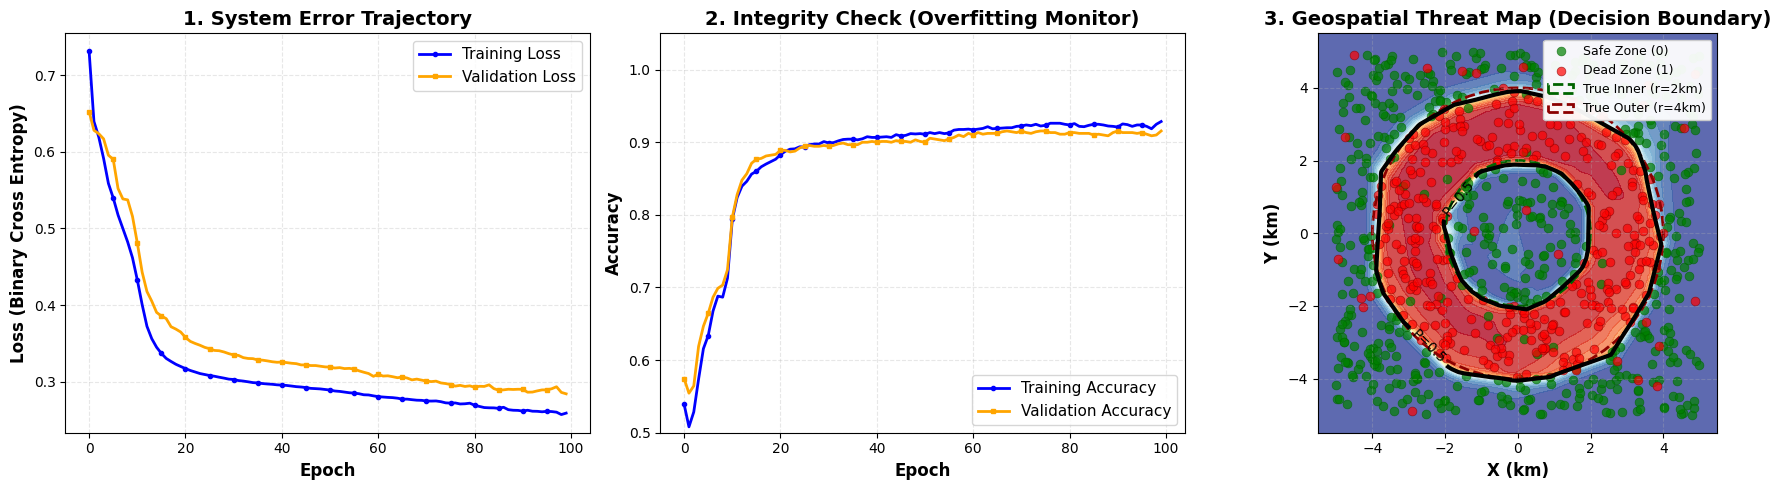


✅ GDC Dashboard saved as 'GDC_Dashboard.png'


In [20]:
# 3 panel dashboard
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PANEL 1: System Error Trajectory (Loss Plot)
axes[0].plot(train_losses, label='Training Loss', color='blue', linewidth=2, marker='o', markersize=3, markevery=5)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2, marker='s', markersize=3, markevery=5)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (Binary Cross Entropy)', fontsize=12, fontweight='bold')
axes[0].set_title('1. System Error Trajectory', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# PANEL 2: Integrity Check (Accuracy Plot)
axes[1].plot(train_accuracies, label='Training Accuracy', color='blue', linewidth=2, marker='o', markersize=3, markevery=5)
axes[1].plot(val_accuracies, label='Validation Accuracy', color='orange', linewidth=2, marker='s', markersize=3, markevery=5)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('2. Integrity Check (Overfitting Monitor)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11, loc='lower right')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_ylim([0.5, 1.05])

# PANEL 3: Geospatial Threat Map (Decision Boundary)
# Create mesh grid
x_min, x_max = X_val[:, 0].min() - 0.5, X_val[:, 0].max() + 0.5
y_min, y_max = X_val[:, 1].min() - 0.5, X_val[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                      np.linspace(y_min, y_max, 200))

Z = np.c_[xx.ravel(), yy.ravel()]
Z = torch.tensor(Z, dtype=torch.float32)

with torch.no_grad():
    Z_pred = model.forward(Z).numpy()
    Z_pred = Z_pred.reshape(xx.shape)

# Plot decision boundary contours
axes[2].contourf(xx, yy, Z_pred, levels=20, cmap='RdYlBu_r', alpha=0.8)
contour = axes[2].contour(xx, yy, Z_pred, levels=[0.5], colors='black', linewidths=3)
axes[2].clabel(contour, inline=True, fontsize=10, fmt='P=0.5')

# Separate safe and dead zones
safe_zone = (y_val == 0).squeeze()
dead_zone = (y_val == 1).squeeze()

# Scatter plot
axes[2].scatter(X_val[safe_zone, 0], X_val[safe_zone, 1], c='green', label='Safe Zone (0)', alpha=0.7, s=40, edgecolors='darkgreen', linewidth=0.5)
axes[2].scatter(X_val[dead_zone, 0], X_val[dead_zone, 1], c='red', label='Dead Zone (1)', alpha=0.7, s=40, edgecolors='darkred', linewidth=0.5)

# Draw true boundaries
circle_inner = plt.Circle((0, 0), 2, fill=False, color='darkgreen', linestyle='--', linewidth=2, label='True Inner (r=2km)')
circle_outer = plt.Circle((0, 0), 4, fill=False, color='darkred', linestyle='--', linewidth=2, label='True Outer (r=4km)')
axes[2].add_patch(circle_inner)
axes[2].add_patch(circle_outer)

axes[2].set_xlabel('X (km)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Y (km)', fontsize=12, fontweight='bold')
axes[2].set_title('3. Geospatial Threat Map (Decision Boundary)', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=9, loc='upper right', framealpha=0.95)
axes[2].set_aspect('equal')
axes[2].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('GDC_Dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ GDC Dashboard saved as 'GDC_Dashboard.png'")

## Part 6: Final Metrics Summary

In [21]:
# Calculate final metrics
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
accuracy_delta = final_train_acc - final_val_acc

print("\n" + "="*70)
print("FINAL METRICS SUMMARY")
print("="*70)
print(f"Final Training Loss:      {final_train_loss:.6f}")
print(f"Final Validation Loss:    {final_val_loss:.6f}")
print(f"Final Training Accuracy:  {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"\nOverfitting Check:")
print(f"  Δ Accuracy (Train - Val): {accuracy_delta:.4f}")

if accuracy_delta < 0.15:
    print("  ✅ Model generalization is GOOD (minimal overfitting)")
elif accuracy_delta < 0.25:
    print("   Model has moderate overfitting")
else:
    print("   Model is significantly overfitting")



FINAL METRICS SUMMARY
Final Training Loss:      0.258952
Final Validation Loss:    0.284106
Final Training Accuracy:  0.9286 (92.86%)
Final Validation Accuracy: 0.9156 (91.56%)

Overfitting Check:
  Δ Accuracy (Train - Val): 0.0130
  ✅ Model generalization is GOOD (minimal overfitting)
